In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import font_manager, rc

In [2]:
# 한글 깨짐 방지 코드
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
# 월별 통합 데이터 = df
df = pd.read_csv('../pre_data/월별_통합_모델링용.csv',index_col=0)
df.head()

,date,닭고기가격,병아리(원/수),hot_day,import amount,feedprice,oil_avg,도축,소_소비자가_int,돼지_소비자가_int,미국기준금리,한국기준금리
0,2012-01-31,3202,250,0,8754,533.6,107.066111,58873,59981,18465,0.25,3.25
2,2012-02-29,3668,420,0,10098,529.9,112.537302,55879,56019,16634,0.75,3.25
3,2012-03-31,4169,500,0,10836,527.9,117.745606,58750,50899,16317,0.25,3.25
4,2012-04-30,3399,332,0,13412,526.3,113.723667,60940,53879,15882,0.25,3.25
5,2012-05-31,3255,200,0,14519,526.2,104.184710,73505,55403,16798,0.25,3.25


In [6]:
# 일별 통합 데이터 = data
data = pd.read_csv('../pre_data/일별_통합_모델링용.csv',index_col=0)
data = data.drop(columns='한국기준금리')
data

,date,price,병아리(원/수),oil_avg,소_소비자가_int,돼지_소비자가_int,미국기준금리
0,2021-12-31,4047,400,76.703333,111396,25177,0.25
1,2021-12-30,4047,400,77.850000,111396,25411,0.25
2,2021-12-29,3895,400,77.566667,112019,26891,0.25
3,2021-12-28,3895,400,77.130000,110865,26936,0.25
4,2021-12-27,3743,400,76.530000,109225,26993,0.25
...,...,...,...,...,...,...,...
2991,2012-01-06,3166,200,108.180000,58380,19570,0.75
2992,2012-01-05,3118,200,108.260000,58870,19830,0.75
2993,2012-01-04,3118,300,108.470000,61700,20300,0.75
2994,2012-01-03,3118,300,107.000000,61030,20330,0.75


### Prophet

In [12]:
# 일별 통합 데이터 = data
data = pd.read_csv('../데이터전처리/pre_data/일별_통합.csv',index_col=0)
data = data[['date','price','병아리(원/수)', 'oil_avg', '일별_평균기온', '일별_최저기온', '일별_최고기온']]
data.fillna(method='ffill',inplace=True) # 일별 데이터 data에서 유가 null 값을 null 뒤에 값으로 채움
data

,date,price,병아리(원/수),oil_avg,일별_평균기온,일별_최저기온,일별_최고기온
0,2021-12-31,4047,400.0,76.703333,-3.9,-7.2,0.1
1,2021-12-30,4047,400.0,77.850000,-0.7,-3.3,2.7
2,2021-12-29,3895,400.0,77.566667,2.5,-2.5,7.5
3,2021-12-28,3895,400.0,77.130000,0.0,-5.2,4.9
4,2021-12-27,3743,400.0,76.530000,-4.6,-11.2,0.5
...,...,...,...,...,...,...,...
2991,2012-01-06,3166,200.0,108.180000,-2.6,-7.8,3.7
2992,2012-01-05,3118,200.0,108.260000,-4.1,-8.7,1.5
2993,2012-01-04,3118,300.0,108.470000,-4.0,-6.6,-1.0
2994,2012-01-03,3118,300.0,107.000000,-1.9,-5.8,2.8


In [53]:
# !pip install Prophet

In [54]:
# prophet은 ds,y라는 두가지 컬럼만 있어야 함(컬럼 이름 맞추기)
data = data[['date', 'price']]
data = data.rename(columns=({'date':'ds','price':'y'}))

In [55]:
from prophet import Prophet

m = Prophet()
m.fit(data)

09:46:39 - cmdstanpy - INFO - Chain [1] start processing
09:46:40 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3356,2022-12-27
3357,2022-12-28
3358,2022-12-29
3359,2022-12-30
3360,2022-12-31


In [57]:
# yhat(예측값), yhat_lower(예측 최소값), yhat_upper(예측 최대값)

forecast = m.predict(future)
forecast = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail()
# forecast.to_csv('./prophet_예측값.csv')

,ds,yhat,yhat_lower,yhat_upper
3356,2022-12-27,3897.764778,3372.175557,4448.448621
3357,2022-12-28,3916.594962,3338.265545,4424.394835
3358,2022-12-29,3936.428393,3407.147319,4500.386104
3359,2022-12-30,3940.591082,3438.241775,4499.438730
3360,2022-12-31,3934.225106,3403.024879,4496.652343


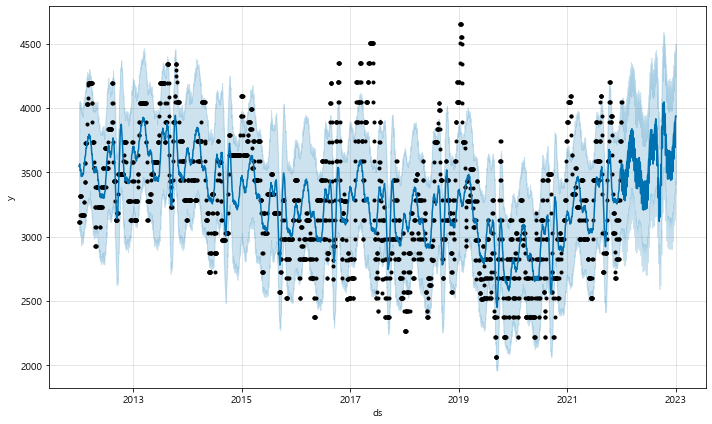

In [58]:
# 예측값 시각화
fig1 = m.plot(forecast)
# 검정색 점 : 실제 데이터 값
# 파란색 실선 : 예측값
# 하늘색 범위 : lower, upper 영역

##### 상한가, 하한가 지정

In [60]:
# 상한가를 4500, 하한가 2000으로 제한
data['cap'] = 4500
data['floor'] = 2000

m = Prophet()
m.fit(data)

09:47:00 - cmdstanpy - INFO - Chain [1] start processing
09:47:01 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
future = m.make_future_dataframe(periods=365)
future['cap'] = 4500
future['floor'] = 2000

forecast = m.predict(future)
# forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3356,2022-12-27,3811.015706,4500,3333.375659,4453.505335,3610.369701,4013.935466,86.749073,86.749073,86.749073,14.640029,14.640029,14.640029,72.109043,72.109043,72.109043,0.0,0.0,0.0,3897.764778
3357,2022-12-28,3812.031938,4500,3366.058399,4473.658630,3610.780874,4016.213239,104.563025,104.563025,104.563025,27.087407,27.087407,27.087407,77.475617,77.475617,77.475617,0.0,0.0,0.0,3916.594962
3358,2022-12-29,3813.048170,4500,3328.176831,4437.152282,3611.192047,4018.150631,123.380223,123.380223,123.380223,41.835787,41.835787,41.835787,81.544436,81.544436,81.544436,0.0,0.0,0.0,3936.428393
3359,2022-12-30,3814.064402,4500,3370.085426,4514.749395,3611.603220,4019.730864,126.526680,126.526680,126.526680,42.217878,42.217878,42.217878,84.308802,84.308802,84.308802,0.0,0.0,0.0,3940.591082
3360,2022-12-31,3815.080634,4500,3379.681166,4483.649762,3612.014393,4022.329326,119.144472,119.144472,119.144472,33.361751,33.361751,33.361751,85.782721,85.782721,85.782721,0.0,0.0,0.0,3934.225106


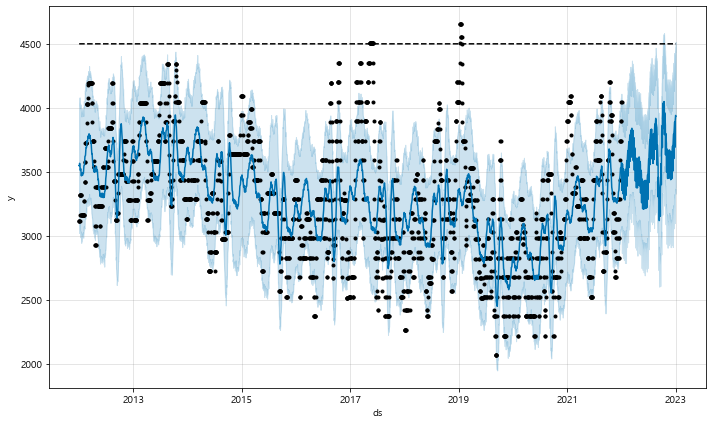

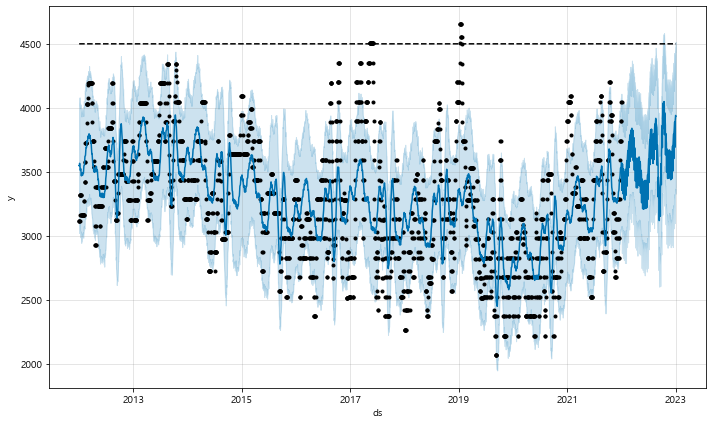

In [62]:
m.plot(forecast)

##### holidays 지정

In [25]:
# !pip install korean_lunar_calendar

In [26]:
# from korean_lunar_calendar import KoreanLunarCalendar

# calendar = KoreanLunarCalendar()

# def lunar_to_solar(year, month, day):
#     calendar.setLunarDate(year,month,day, False)
#     cal = calendar.SolarIsoFormat()
#     return cal

In [27]:
# lunar_new_year = []

# for i in range(0,11):
#     lunar_new_year.append(lunar_to_solar(2011+i, 1, 1)) 

In [28]:
# Chu_seok = []

# for c in range(0,11):
#     Chu_seok.append(lunar_to_solar(2011+c,8,15))

In [63]:
# new_year = pd.DataFrame({
# 'holiday': 'new_year',
# 'ds': pd.to_datetime(['2011-01-01','2012-01-01', '2013-01-01',
#                       '2014-01-01', '2015-01-01', '2016-01-01',
#                       '2017-01-01', '2018-01-01', '2019-01-01',
#                       '2020-01-01', '2021-01-01']),
# 'lower_window': 0,
# 'upper_window': 1,
# })

# lunar_new_year = pd.DataFrame({
#     'holiday': 'lunar_new_year',
#     'ds': lunar_new_year,
#     'lower_window': 0,
#     'upper_window': 1,
#   })

# Chu_seok = pd.DataFrame({
#     'holiday': 'Chu_seok',
#     'ds': Chu_seok,
#     'lower_window': 0,
#     'upper_window': 1,
#   })

Bok_nal = pd.DataFrame({
'holiday': 'Bok_nal',
'ds': pd.to_datetime(['2011-07-14', '2011-07-24', '2011-08-13',
                      '2012-07-18', '2012-07-28','2012-08-07',
                      '2013-07-13', '2013-07-23', '2013-08-12',
                      '2014-07-18', '2014-07-28', '2014-08-07',
                      '2015-07-13', '2015-07-23', '2015-08-12',
                      '2016-07-17', '2016-07-27', '2016-08-16',
                      '2017-07-12', '2017-07-22', '2017-08-11',
                      '2018-07-17', '2018-07-27', '2018-08-16',
                      '2019-07-12', '2019-07-22', '2019-08-11',
                      '2020-07-16', '2020-07-26', '2020-08-15',
                      '2021-07-11', '2021-07-21', '2021-08-10'
                      ]),
'lower_window': 0,
'upper_window': 1,
})

AI = pd.DataFrame({
'holiday': 'AI',
'ds': pd.to_datetime([
    '2015-01-14', '2015-01-21', '2015-01-22','2015-01-23', '2015-01-31', 
    '2015-02-10', '2015-03-09', '2015-03-10', '2015-03-15', '2015-03-26', 
    '2015-03-28', '2015-03-31', '2015-04-01', '2015-04-03', '2015-04-05', 
    '2015-04-06', '2015-04-10', '2015-04-11', '2015-04-13', '2015-04-14', 
    '2015-04-20', '2016-11-16', '2016-11-22', '2016-11-23', '2016-11-26', 
    '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30', '2016-12-01',
    '2016-12-02', '2016-12-03', '2016-12-04', '2016-12-05', '2016-12-06', 
    '2016-12-07', '2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11', 
    '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
    '2016-12-17', '2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21', 
    '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26', 
    '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
    '2017-01-01', '2017-01-03', '2017-01-05', '2017-01-07', '2017-01-08', 
    '2017-01-09', '2017-01-10', '2017-01-12', '2017-01-14', '2017-01-20', 
    '2017-01-21', '2017-01-24', '2017-02-06', '2017-02-09', '2017-02-22', 
    '2017-02-27', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-06', 
    '2017-03-17', '2017-03-19', '2017-03-22', '2017-03-23', '2017-03-26', 
    '2017-03-27', '2017-03-29', '2017-04-02', '2017-06-03', '2018-01-03', 
    '2018-01-26', '2018-01-27', '2018-02-04', '2018-02-08', '2018-03-16', 
    '2018-03-17',
    '2020-12-06', '2020-12-12', '2020-12-14', '2020-12-16', '2020-12-21', 
    '2020-12-22', '2020-12-25', '2020-12-28', '2020-12-28', '2020-12-29',
    '2020-12-29', '2020-12-31', '2021-01-01', '2021-01-03', '2021-01-04',
    '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-11', '2021-01-12',
    '2021-01-13', '2021-01-18', '2021-01-21', '2021-01-22', '2021-01-23',
    '2021-01-26', '2021-01-26', '2021-01-27', '2021-01-29', '2021-01-30',
    '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-09', '2021-02-12', 
    '2021-02-13', '2021-02-15', '2021-02-17', '2021-02-22', '2021-02-23',
    '2021-02-26', '2021-03-10', '2021-03-10', '2021-03-11', '2021-11-19',
    '2021-12-03', '2021-12-05', '2021-12-11', '2021-12-14', '2021-12-16',
    '2021-12-20', '2021-12-23', '2022-01-21', '2022-01-21', '2022-01-23',
    '2022-01-29', '2022-10-21'
                      ]),
'lower_window': 0,
'upper_window': 1,
})

# holidays = pd.concat((new_year, lunar_new_year,Chu_seok,Bok_nal))
holidays = pd.concat((Bok_nal, AI))

In [64]:
# add_country_holidays(country_name = 'KR')에 공휴일 다 등록되어 있어서, 임의로 넣은 설날 추석 빼고 복날이랑 조류 인플루엔자가 10,000건 이상 발생한 일자만 넣음
holidays

,holiday,ds,lower_window,upper_window
0,Bok_nal,2011-07-14,0,1
1,Bok_nal,2011-07-24,0,1
2,Bok_nal,2011-08-13,0,1
3,Bok_nal,2012-07-18,0,1
4,Bok_nal,2012-07-28,0,1
...,...,...,...,...
147,AI,2022-01-21,0,1
148,AI,2022-01-21,0,1
149,AI,2022-01-23,0,1
150,AI,2022-01-29,0,1


In [65]:
# 한국 공휴일과 복날 반영, chagepoint 유연성 조정(원래 chagepoint_prior_scale은 0.05임)
# data['cap'] = 4500
# data['floor'] = 1500

m = Prophet(holidays=holidays, changepoint_prior_scale=0.5, seasonality_mode='multiplicative', interval_width=0.95)
m.add_country_holidays(country_name = 'KR').fit(data)

future = m.make_future_dataframe(periods=30)
# future['cap'] = 4500
# future['floor'] = 1500

forcast = m.predict(future)
# forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail()

09:47:20 - cmdstanpy - INFO - Chain [1] start processing
09:47:26 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3356,2022-12-27,3811.015706,4500,3333.375659,4453.505335,3610.369701,4013.935466,86.749073,86.749073,86.749073,14.640029,14.640029,14.640029,72.109043,72.109043,72.109043,0.0,0.0,0.0,3897.764778
3357,2022-12-28,3812.031938,4500,3366.058399,4473.658630,3610.780874,4016.213239,104.563025,104.563025,104.563025,27.087407,27.087407,27.087407,77.475617,77.475617,77.475617,0.0,0.0,0.0,3916.594962
3358,2022-12-29,3813.048170,4500,3328.176831,4437.152282,3611.192047,4018.150631,123.380223,123.380223,123.380223,41.835787,41.835787,41.835787,81.544436,81.544436,81.544436,0.0,0.0,0.0,3936.428393
3359,2022-12-30,3814.064402,4500,3370.085426,4514.749395,3611.603220,4019.730864,126.526680,126.526680,126.526680,42.217878,42.217878,42.217878,84.308802,84.308802,84.308802,0.0,0.0,0.0,3940.591082
3360,2022-12-31,3815.080634,4500,3379.681166,4483.649762,3612.014393,4022.329326,119.144472,119.144472,119.144472,33.361751,33.361751,33.361751,85.782721,85.782721,85.782721,0.0,0.0,0.0,3934.225106


In [49]:
# trend 반영 후 예측 값
forecast.tail()
forecast.to_csv('./trend_반영_prophet_예측값.csv')

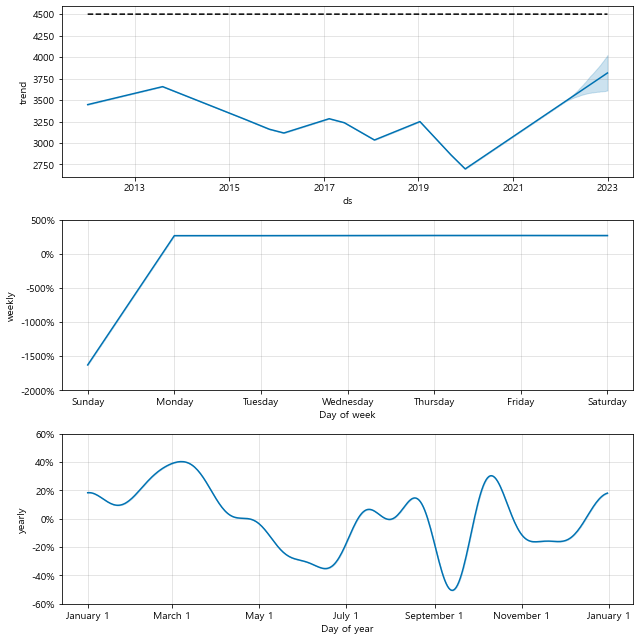

In [66]:
fig = m.plot_components(forecast)
# 시계열 추세, 연간 계절성, 주간 계절성 표시

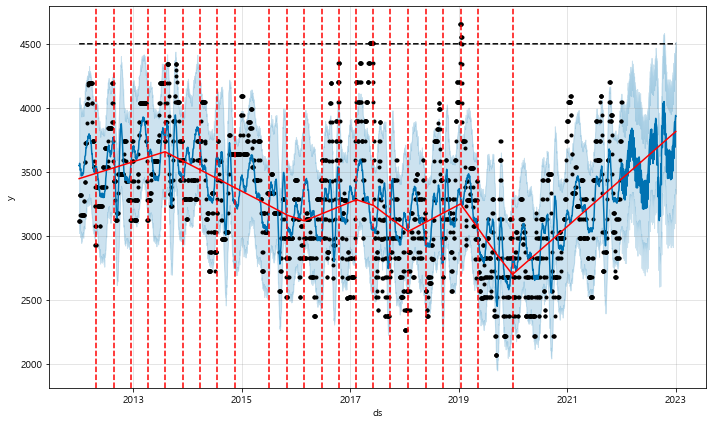

In [67]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# 빨간 점선 : ChangePoint
# 빨간 실선 : Trend
# 검정색 점 : 실제 데이터 값
# 파란색 실선 : 예측 값
# 하늘색 범위 : lower, upper 영역

In [68]:
# trend 반영 전후 비교
trend_pred = pd.read_csv('./trend_반영_prophet_예측값.csv')
not_trend_pred = pd.read_csv('./prophet_예측값.csv')

In [38]:
# trend 반영한 2022년 예측값만 뽑아냄
trend_pred['ds'] = pd.to_datetime(trend_pred['ds'])
trend_pred['year'] = trend_pred['ds'].dt.year
trend_pred = trend_pred.query('year==2022')
trend_pred

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,year
2996,2996,2022-01-01,3458.799399,3108.281118,4031.975717,3458.799399,3458.799399,0.0,0.0,0.0,...,35.001290,35.001290,91.276827,91.276827,91.276827,0.0,0.0,0.0,3585.077517,2022
2997,2997,2022-01-02,3459.863873,2868.730310,3856.079885,3459.863873,3459.863873,0.0,0.0,0.0,...,-179.623456,-179.623456,90.050646,90.050646,90.050646,0.0,0.0,0.0,3370.291064,2022
2998,2998,2022-01-03,3460.928348,3087.138933,4073.170451,3460.928348,3460.928348,0.0,0.0,0.0,...,16.305012,16.305012,87.667275,87.667275,87.667275,0.0,0.0,0.0,3564.900636,2022
2999,2999,2022-01-04,3461.992823,3043.827120,4051.033352,3461.992823,3461.992823,0.0,0.0,0.0,...,15.777608,15.777608,84.222549,84.222549,84.222549,0.0,0.0,0.0,3561.992980,2022
3000,3000,2022-01-05,3463.057298,3067.443580,4076.988799,3463.057298,3463.057298,0.0,0.0,0.0,...,28.333949,28.333949,79.827292,79.827292,79.827292,0.0,0.0,0.0,3571.218538,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,3356,2022-12-27,3842.010291,3401.351015,4443.943187,3651.662814,4066.942879,0.0,0.0,0.0,...,15.777608,15.777608,76.430802,76.430802,76.430802,0.0,0.0,0.0,3934.218701,2022
3357,3357,2022-12-28,3843.074766,3435.661907,4522.890343,3652.021785,4069.595817,0.0,0.0,0.0,...,28.333949,28.333949,82.112287,82.112287,82.112287,0.0,0.0,0.0,3953.521001,2022
3358,3358,2022-12-29,3844.139240,3424.292848,4533.673382,3652.380756,4072.248755,0.0,0.0,0.0,...,41.489865,41.489865,86.447411,86.447411,86.447411,0.0,0.0,0.0,3972.076517,2022
3359,3359,2022-12-30,3845.203715,3446.587513,4534.281698,3651.654909,4074.490535,0.0,0.0,0.0,...,42.715731,42.715731,89.426956,89.426956,89.426956,0.0,0.0,0.0,3977.346403,2022


In [39]:
# trend 반영하지 않은 2022년 예측값만 뽑아냄
not_trend_pred['ds'] = pd.to_datetime(not_trend_pred['ds'])
not_trend_pred['year'] = not_trend_pred['ds'].dt.year
not_trend_pred = not_trend_pred.query('year==2022')
not_trend_pred

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,year
2996,2996,2022-01-01,3458.799399,3108.281118,4031.975717,3458.799399,3458.799399,0.0,0.0,0.0,...,35.001290,35.001290,91.276827,91.276827,91.276827,0.0,0.0,0.0,3585.077517,2022
2997,2997,2022-01-02,3459.863873,2868.730310,3856.079885,3459.863873,3459.863873,0.0,0.0,0.0,...,-179.623456,-179.623456,90.050646,90.050646,90.050646,0.0,0.0,0.0,3370.291064,2022
2998,2998,2022-01-03,3460.928348,3087.138933,4073.170451,3460.928348,3460.928348,0.0,0.0,0.0,...,16.305012,16.305012,87.667275,87.667275,87.667275,0.0,0.0,0.0,3564.900636,2022
2999,2999,2022-01-04,3461.992823,3043.827120,4051.033352,3461.992823,3461.992823,0.0,0.0,0.0,...,15.777608,15.777608,84.222549,84.222549,84.222549,0.0,0.0,0.0,3561.992980,2022
3000,3000,2022-01-05,3463.057298,3067.443580,4076.988799,3463.057298,3463.057298,0.0,0.0,0.0,...,28.333949,28.333949,79.827292,79.827292,79.827292,0.0,0.0,0.0,3571.218538,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,3356,2022-12-27,3842.010291,3401.351015,4443.943187,3651.662814,4066.942879,0.0,0.0,0.0,...,15.777608,15.777608,76.430802,76.430802,76.430802,0.0,0.0,0.0,3934.218701,2022
3357,3357,2022-12-28,3843.074766,3435.661907,4522.890343,3652.021785,4069.595817,0.0,0.0,0.0,...,28.333949,28.333949,82.112287,82.112287,82.112287,0.0,0.0,0.0,3953.521001,2022
3358,3358,2022-12-29,3844.139240,3424.292848,4533.673382,3652.380756,4072.248755,0.0,0.0,0.0,...,41.489865,41.489865,86.447411,86.447411,86.447411,0.0,0.0,0.0,3972.076517,2022
3359,3359,2022-12-30,3845.203715,3446.587513,4534.281698,3651.654909,4074.490535,0.0,0.0,0.0,...,42.715731,42.715731,89.426956,89.426956,89.426956,0.0,0.0,0.0,3977.346403,2022


In [40]:
trend_pred.columns

Index(['Unnamed: 0', 'ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'Alternative holiday of Children's Day',
       'Alternative holiday of Children's Day_lower',
       'Alternative holiday of Children's Day_upper',
       ...
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'year'],
      dtype='object', length=105)

In [41]:
trend_pred = trend_pred[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower','trend_upper', 'yhat']]
not_trend_pred = not_trend_pred[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower','trend_upper', 'yhat']]

In [42]:
all_pred = pd.merge(trend_pred,not_trend_pred,how='outer', on='ds')
all_pred

,ds,trend_x,yhat_lower_x,yhat_upper_x,trend_lower_x,trend_upper_x,yhat_x,trend_y,yhat_lower_y,yhat_upper_y,trend_lower_y,trend_upper_y,yhat_y
0,2022-01-01,3458.799399,3108.281118,4031.975717,3458.799399,3458.799399,3585.077517,3458.799399,3108.281118,4031.975717,3458.799399,3458.799399,3585.077517
1,2022-01-02,3459.863873,2868.730310,3856.079885,3459.863873,3459.863873,3370.291064,3459.863873,2868.730310,3856.079885,3459.863873,3459.863873,3370.291064
2,2022-01-03,3460.928348,3087.138933,4073.170451,3460.928348,3460.928348,3564.900636,3460.928348,3087.138933,4073.170451,3460.928348,3460.928348,3564.900636
3,2022-01-04,3461.992823,3043.827120,4051.033352,3461.992823,3461.992823,3561.992980,3461.992823,3043.827120,4051.033352,3461.992823,3461.992823,3561.992980
4,2022-01-05,3463.057298,3067.443580,4076.988799,3463.057298,3463.057298,3571.218538,3463.057298,3067.443580,4076.988799,3463.057298,3463.057298,3571.218538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,3842.010291,3401.351015,4443.943187,3651.662814,4066.942879,3934.218701,3842.010291,3401.351015,4443.943187,3651.662814,4066.942879,3934.218701
361,2022-12-28,3843.074766,3435.661907,4522.890343,3652.021785,4069.595817,3953.521001,3843.074766,3435.661907,4522.890343,3652.021785,4069.595817,3953.521001
362,2022-12-29,3844.139240,3424.292848,4533.673382,3652.380756,4072.248755,3972.076517,3844.139240,3424.292848,4533.673382,3652.380756,4072.248755,3972.076517
363,2022-12-30,3845.203715,3446.587513,4534.281698,3651.654909,4074.490535,3977.346403,3845.203715,3446.587513,4534.281698,3651.654909,4074.490535,3977.346403


In [43]:
check_dupli = all_pred['yhat_x'] == all_pred['yhat_y']
pd.Series.unique(check_dupli)
# trend열 기준으로 trend 반영 전/후 결과가 똑같음

array([ True])

#### prophet 교차검증

In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m,initial='1095 days', period='180 days', horizon='30 days')
df_cv.head()

  0%|          | 0/15 [00:00<?, ?it/s]17:17:09 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:17:09 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:17:09 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 01:21 Sampling completed                     
chain 2 |██████████| 01:21 Sampling completed                     
chain 3 |██████████| 01:21 Sampling completed                     
chain 4 |██████████| 01:21 Sampling completed                     


17:18:30 - cmdstanpy - INFO - CmdStan done processing.
17:18:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan',

  7%|▋         | 1/15 [01:22<19:19, 82.86s/it]17:18:32 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:18:32 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:18:32 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 02:38 Sampling completed                     
chain 2 |██████████| 02:38 Sampling completed                     
chain 3 |██████████| 02:38 Sampling completed                     
chain 4 |██████████| 02:38 Sampling completed                     


17:21:10 - cmdstanpy - INFO - CmdStan done processing.
17:21:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, c

17:21:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use function "diagnose()" to see further information.
 13%|█▎        | 2/15 [04:03<27:55, 128.91s/it]17:21:13 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:21:13 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:21:13 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 03:23 Sampling completed                     
chain 2 |██████████| 03:23 Sampling completed                     
chain 3 |██████████| 03:23 Sampling completed   


17:24:37 - cmdstanpy - INFO - CmdStan done processing.
17:24:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan',

 20%|██        | 3/15 [07:30<32:49, 164.14s/it]17:24:39 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:24:39 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:24:39 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 04:50 Sampling completed                     
chain 2 |██████████| 04:50 Sampling completed                     
chain 3 |██████████| 04:50 Sampling completed                     
chain 4 |██████████| 04:50 Sampling completed                     


17:29:30 - cmdstanpy - INFO - CmdStan done processing.
17:29:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, c

 27%|██▋       | 4/15 [12:23<39:27, 215.24s/it]17:29:33 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:29:33 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:29:33 - cmdstanpy - INFO - CmdStan start processing

































chain 1 |██████████| 04:46 Sampling completed                     
chain 2 |██████████| 04:46 Sampling completed                     
chain 3 |██████████| 04:46 Sampling completed                     
chain 4 |██████████| 04:46 Sampling completed                     


17:34:19 - cmdstanpy - INFO - CmdStan done processing.
17:34:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan',

 33%|███▎      | 5/15 [17:12<40:16, 241.63s/it]17:34:21 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:34:21 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:34:21 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 05:58 Sampling completed                     
chain 2 |██████████| 05:58 Sampling completed                     
chain 3 |██████████| 05:58 Sampling completed                     
chain 4 |██████████| 05:58 Sampling completed                     


17:40:20 - cmdstanpy - INFO - CmdStan done processing.
17:40:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 40%|████      | 6/15 [23:12<42:18, 282.02s/it]17:40:22 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:40:22 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:40:22 - cmdstanpy - INFO - CmdStan start processing

































chain 1 |██████████| 07:06 Sampling completed                     
chain 2 |██████████| 07:06 Sampling completed                     
chain 3 |██████████| 07:06 Sampling completed                     
chain 4 |██████████| 07:06 Sampling completed                     


17:47:29 - cmdstanpy - INFO - CmdStan done processing.
17:47:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 47%|████▋     | 7/15 [30:21<44:00, 330.00s/it]17:47:30 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:47:30 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:47:30 - cmdstanpy - INFO - CmdStan start processing

































chain 1 |██████████| 06:17 Sampling completed                     
chain 2 |██████████| 06:17 Sampling completed                     
chain 3 |██████████| 06:17 Sampling completed                     
chain 4 |██████████| 06:17 Sampling completed                     


17:53:48 - cmdstanpy - INFO - CmdStan done processing.
17:53:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 53%|█████▎    | 8/15 [36:41<40:20, 345.84s/it]17:53:50 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:53:50 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:53:50 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 10:22 Sampling completed                     
chain 2 |██████████| 10:22 Sampling completed                     
chain 3 |██████████| 10:22 Sampling completed                     
chain 4 |██████████| 10:22 Sampling completed                     


18:04:13 - cmdstanpy - INFO - CmdStan done processing.
18:04:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 60%|██████    | 9/15 [47:05<43:18, 433.06s/it]18:04:15 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
18:04:15 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:04:15 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 09:20 Sampling completed                     
chain 2 |██████████| 09:20 Sampling completed                     
chain 3 |██████████| 09:20 Sampling completed                     
chain 4 |██████████| 09:20 Sampling completed                     


18:13:35 - cmdstanpy - INFO - CmdStan done processing.
18:13:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 67%|██████▋   | 10/15 [56:28<39:24, 472.97s/it]18:13:37 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
18:13:37 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:13:37 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 11:13 Sampling completed                     
chain 2 |██████████| 11:13 Sampling completed                     
chain 3 |██████████| 11:13 Sampling completed                     
chain 4 |██████████| 11:13 Sampling completed                     


18:24:51 - cmdstanpy - INFO - CmdStan done processing.
18:24:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 73%|███████▎  | 11/15 [1:07:44<35:40, 535.05s/it]18:24:53 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
18:24:53 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:24:53 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 13:00 Sampling completed                     
chain 2 |██████████| 13:00 Sampling completed                     
chain 3 |██████████| 13:00 Sampling completed                     
chain 4 |██████████| 13:00 Sampling completed                     


18:37:54 - cmdstanpy - INFO - CmdStan done processing.
18:37:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 80%|████████  | 12/15 [1:20:46<30:31, 610.38s/it]18:37:56 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
18:37:56 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:37:56 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 15:41 Sampling completed                     
chain 2 |██████████| 15:41 Sampling completed                     
chain 3 |██████████| 15:41 Sampling completed                     
chain 4 |██████████| 15:41 Sampling completed                     


18:53:37 - cmdstanpy - INFO - CmdStan done processing.
18:53:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

 87%|████████▋ | 13/15 [1:36:30<23:42, 711.30s/it]18:53:39 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
18:53:39 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:53:39 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 16:46 Sampling completed                     
chain 2 |██████████| 16:46 Sampling completed                     
chain 3 |██████████| 16:46 Sampling completed                     
chain 4 |██████████| 16:46 Sampling completed                     


19:10:26 - cmdstanpy - INFO - CmdStan done processing.
19:10:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, co

19:10:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use function "diagnose()" to see further information.
 93%|█████████▎| 14/15 [1:53:19<13:21, 801.21s/it]19:10:28 - cmdstanpy - INFO - CmdStan installation C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
19:10:28 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
19:10:28 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 17:39 Sampling completed                     
chain 2 |██████████| 17:39 Sampling completed                     
chain 3 |██████████| 17:39 Sampling com


19:28:08 - cmdstanpy - INFO - CmdStan done processing.
19:28:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, co

19:28:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use function "diagnose()" to see further information.
100%|██████████| 15/15 [2:11:00<00:00, 524.06s/it]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-08,4293.724917,3894.872012,4550.644126,3791,2015-01-07
1,2015-01-09,4328.449459,3928.687349,4593.375625,3638,2015-01-07
2,2015-01-10,4347.954759,3912.951090,4613.221177,3638,2015-01-07
3,2015-01-12,4384.749703,3968.440469,4653.874428,3638,2015-01-07
4,2015-01-13,4406.719857,3966.778687,4687.151634,3638,2015-01-07


#### 모델 성능 확인

In [ ]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.215713e+05,567.072588,442.733575,0.141260,0.117659,0.135700,0.738046
1,4 days,3.246203e+05,569.754571,441.253042,0.143075,0.118762,0.136411,0.729730
2,5 days,3.492663e+05,590.987570,457.935568,0.150896,0.168696,0.141453,0.702703
3,6 days,3.850351e+05,620.511955,481.120292,0.163829,0.162426,0.150364,0.630631
4,7 days,3.928164e+05,626.750630,501.344094,0.168735,0.162426,0.158645,0.611227
5,8 days,5.135734e+05,716.640382,551.464004,0.187656,0.162426,0.181872,0.634096
6,9 days,5.790056e+05,760.924171,592.953363,0.199794,0.172306,0.193249,0.604990
7,10 days,6.598709e+05,812.324355,649.106660,0.220644,0.183567,0.208578,0.567568
8,11 days,5.773538e+05,759.838028,636.596941,0.215679,0.194596,0.200324,0.486486
9,12 days,5.291933e+05,727.456761,611.863341,0.204436,0.189188,0.189929,0.513514


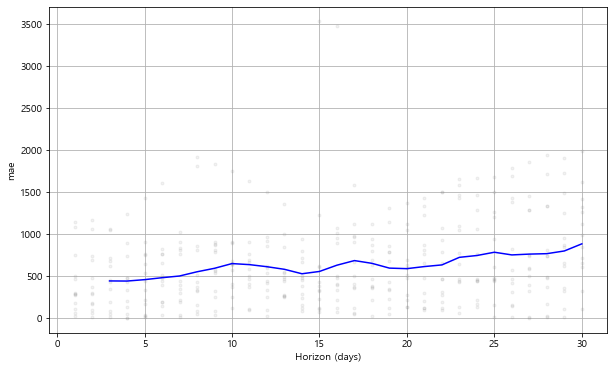

In [ ]:
# 교차 검증 시각화
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mae')

#### 5년치 데이터로 prophet 학습

In [13]:
data

,date,price,병아리(원/수),oil_avg,일별_평균기온,일별_최저기온,일별_최고기온
0,2021-12-31,4047,400.0,76.703333,-3.9,-7.2,0.1
1,2021-12-30,4047,400.0,77.850000,-0.7,-3.3,2.7
2,2021-12-29,3895,400.0,77.566667,2.5,-2.5,7.5
3,2021-12-28,3895,400.0,77.130000,0.0,-5.2,4.9
4,2021-12-27,3743,400.0,76.530000,-4.6,-11.2,0.5
...,...,...,...,...,...,...,...
2991,2012-01-06,3166,200.0,108.180000,-2.6,-7.8,3.7
2992,2012-01-05,3118,200.0,108.260000,-4.1,-8.7,1.5
2993,2012-01-04,3118,300.0,108.470000,-4.0,-6.6,-1.0
2994,2012-01-03,3118,300.0,107.000000,-1.9,-5.8,2.8


In [15]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data = data.query('year >= 2016')
data.to_csv('./5년치_닭고기_가격_모델링용.csv')

C:\Users\admin\AppData\Local\Temp\ipykernel_12412\2392254472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
C:\Users\admin\AppData\Local\Temp\ipykernel_12412\2392254472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['date'].dt.year


In [9]:
# prophet은 ds,y라는 두가지 컬럼만 있어야 함(컬럼 이름 맞추기)
data = data[['date', 'price']]
data = data.rename(columns=({'date':'ds','price':'y'}))

In [11]:
years_5_chicken = data
years_5_chicken.to_csv('./5년치_닭고기_가격.csv')

In [129]:
Bok_nal = pd.DataFrame({
'holiday': 'Bok_nal',
'ds': pd.to_datetime(['2016-07-17', '2016-07-27', '2016-08-16',
                      '2017-07-12', '2017-07-22', '2017-08-11',
                      '2018-07-17', '2018-07-27', '2018-08-16',
                      '2019-07-12', '2019-07-22', '2019-08-11',
                      '2020-07-16', '2020-07-26', '2020-08-15',
                      '2021-07-11', '2021-07-21', '2021-08-10'
                      ]),
'lower_window': 0,
'upper_window': 1,
})

AI = pd.DataFrame({
'holiday': 'AI',
'ds': pd.to_datetime([
    '2016-11-16', '2016-11-22', '2016-11-23', '2016-11-26', 
    '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30', '2016-12-01',
    '2016-12-02', '2016-12-03', '2016-12-04', '2016-12-05', '2016-12-06', 
    '2016-12-07', '2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11', 
    '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
    '2016-12-17', '2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21', 
    '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26', 
    '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
    '2017-01-01', '2017-01-03', '2017-01-05', '2017-01-07', '2017-01-08', 
    '2017-01-09', '2017-01-10', '2017-01-12', '2017-01-14', '2017-01-20', 
    '2017-01-21', '2017-01-24', '2017-02-06', '2017-02-09', '2017-02-22', 
    '2017-02-27', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-06', 
    '2017-03-17', '2017-03-19', '2017-03-22', '2017-03-23', '2017-03-26', 
    '2017-03-27', '2017-03-29', '2017-04-02', '2017-06-03', '2018-01-03', 
    '2018-01-26', '2018-01-27', '2018-02-04', '2018-02-08', '2018-03-16', 
    '2018-03-17',
    '2020-12-06', '2020-12-12', '2020-12-14', '2020-12-16', '2020-12-21', 
    '2020-12-22', '2020-12-25', '2020-12-28', '2020-12-28', '2020-12-29',
    '2020-12-29', '2020-12-31', '2021-01-01', '2021-01-03', '2021-01-04',
    '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-11', '2021-01-12',
    '2021-01-13', '2021-01-18', '2021-01-21', '2021-01-22', '2021-01-23',
    '2021-01-26', '2021-01-26', '2021-01-27', '2021-01-29', '2021-01-30',
    '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-09', '2021-02-12', 
    '2021-02-13', '2021-02-15', '2021-02-17', '2021-02-22', '2021-02-23',
    '2021-02-26', '2021-03-10', '2021-03-10', '2021-03-11', '2021-11-19',
    '2021-12-03', '2021-12-05', '2021-12-11', '2021-12-14', '2021-12-16',
    '2021-12-20', '2021-12-23']),
'lower_window': 0,
'upper_window': 1,
})

holidays = pd.concat((Bok_nal, AI))

In [132]:
from prophet import Prophet

m = Prophet(holidays=holidays)
m = m.add_country_holidays(country_name='KR').fit(data)
future = m.make_future_dataframe(periods=30)
forcast = m.predict(future)

14:14:26 - cmdstanpy - INFO - Chain [1] start processing
14:14:26 - cmdstanpy - INFO - Chain [1] done processing


In [133]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-02,3845.252355,3425.883556,4524.518045,3845.252355,3845.252355,128.546013,128.546013,128.546013,10.348077,10.348077,10.348077,118.197936,118.197936,118.197936,0.0,0.0,0.0,3973.798368
1,2012-01-03,3845.659387,3433.518809,4528.024808,3845.659387,3845.659387,124.725909,124.725909,124.725909,8.262630,8.262630,8.262630,116.463279,116.463279,116.463279,0.0,0.0,0.0,3970.385296
2,2012-01-04,3846.066419,3417.386574,4521.594886,3846.066419,3846.066419,135.546774,135.546774,135.546774,22.131492,22.131492,22.131492,113.415281,113.415281,113.415281,0.0,0.0,0.0,3981.613193
3,2012-01-05,3846.473451,3443.210540,4508.674098,3846.473451,3846.473451,146.067276,146.067276,146.067276,36.916877,36.916877,36.916877,109.150399,109.150399,109.150399,0.0,0.0,0.0,3992.540726
4,2012-01-06,3846.880483,3442.226016,4544.219874,3846.880483,3846.880483,141.487312,141.487312,141.487312,37.705252,37.705252,37.705252,103.782060,103.782060,103.782060,0.0,0.0,0.0,3988.367794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,2022-12-27,4333.219166,3792.718086,5055.198863,4104.828397,4542.395494,108.291790,108.291790,108.291790,8.262630,8.262630,8.262630,100.029159,100.029159,100.029159,0.0,0.0,0.0,4441.510956
3357,2022-12-28,4334.331682,3860.981096,5018.456278,4103.900850,4543.917806,128.840638,128.840638,128.840638,22.131492,22.131492,22.131492,106.709146,106.709146,106.709146,0.0,0.0,0.0,4463.172320
3358,2022-12-29,4335.444199,3887.702590,5097.984772,4104.039653,4545.440117,148.836058,148.836058,148.836058,36.916877,36.916877,36.916877,111.919181,111.919181,111.919181,0.0,0.0,0.0,4484.280256
3359,2022-12-30,4336.556715,3896.739358,5068.606691,4104.415710,4547.133827,153.339184,153.339184,153.339184,37.705252,37.705252,37.705252,115.633932,115.633932,115.633932,0.0,0.0,0.0,4489.895899


##### prophet 호수별 닭고기 가격으로 예측해보기

In [99]:
Bok_nal = pd.DataFrame({
'holiday': 'Bok_nal',
'ds': pd.to_datetime(['2011-07-14', '2011-07-24', '2011-08-13',
                      '2012-07-18', '2012-07-28','2012-08-07',
                      '2013-07-13', '2013-07-23', '2013-08-12',
                      '2014-07-18', '2014-07-28', '2014-08-07',
                      '2015-07-13', '2015-07-23', '2015-08-12',
                      '2016-07-17', '2016-07-27', '2016-08-16',
                      '2017-07-12', '2017-07-22', '2017-08-11',
                      '2018-07-17', '2018-07-27', '2018-08-16',
                      '2019-07-12', '2019-07-22', '2019-08-11',
                      '2020-07-16', '2020-07-26', '2020-08-15',
                      '2021-07-11', '2021-07-21', '2021-08-10'
                      ]),
'lower_window': 0,
'upper_window': 1,
})

AI = pd.DataFrame({
'holiday': 'AI',
'ds': pd.to_datetime([
    '2015-01-14', '2015-01-21', '2015-01-22','2015-01-23', '2015-01-31', 
    '2015-02-10', '2015-03-09', '2015-03-10', '2015-03-15', '2015-03-26', 
    '2015-03-28', '2015-03-31', '2015-04-01', '2015-04-03', '2015-04-05', 
    '2015-04-06', '2015-04-10', '2015-04-11', '2015-04-13', '2015-04-14', 
    '2015-04-20', '2016-11-16', '2016-11-22', '2016-11-23', '2016-11-26', 
    '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30', '2016-12-01',
    '2016-12-02', '2016-12-03', '2016-12-04', '2016-12-05', '2016-12-06', 
    '2016-12-07', '2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11', 
    '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
    '2016-12-17', '2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21', 
    '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26', 
    '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
    '2017-01-01', '2017-01-03', '2017-01-05', '2017-01-07', '2017-01-08', 
    '2017-01-09', '2017-01-10', '2017-01-12', '2017-01-14', '2017-01-20', 
    '2017-01-21', '2017-01-24', '2017-02-06', '2017-02-09', '2017-02-22', 
    '2017-02-27', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-06', 
    '2017-03-17', '2017-03-19', '2017-03-22', '2017-03-23', '2017-03-26', 
    '2017-03-27', '2017-03-29', '2017-04-02', '2017-06-03', '2018-01-03', 
    '2018-01-26', '2018-01-27', '2018-02-04', '2018-02-08', '2018-03-16', 
    '2018-03-17',
    '2020-12-06', '2020-12-12', '2020-12-14', '2020-12-16', '2020-12-21', 
    '2020-12-22', '2020-12-25', '2020-12-28', '2020-12-28', '2020-12-29',
    '2020-12-29', '2020-12-31', '2021-01-01', '2021-01-03', '2021-01-04',
    '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-11', '2021-01-12',
    '2021-01-13', '2021-01-18', '2021-01-21', '2021-01-22', '2021-01-23',
    '2021-01-26', '2021-01-26', '2021-01-27', '2021-01-29', '2021-01-30',
    '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-09', '2021-02-12', 
    '2021-02-13', '2021-02-15', '2021-02-17', '2021-02-22', '2021-02-23',
    '2021-02-26', '2021-03-10', '2021-03-10', '2021-03-11', '2021-11-19',
    '2021-12-03', '2021-12-05', '2021-12-11', '2021-12-14', '2021-12-16',
    '2021-12-20', '2021-12-23', '2022-01-21', '2022-01-21', '2022-01-23',
    '2022-01-29', '2022-10-21'
                      ]),
'lower_window': 0,
'upper_window': 1,
})

holidays = pd.concat((Bok_nal, AI))

In [100]:
chicken_price_by_size = pd.read_csv('../데이터전처리/pre_data/치킨_호수별_가격.csv')
chicken_price_by_size['date'] = pd.to_datetime(chicken_price_by_size['date'])
chicken_price_by_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996 entries, 0 to 2995
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2996 non-null   datetime64[ns]
 1   5-6호    2996 non-null   int64         
 2   7-8호    2996 non-null   int64         
 3   9-10호   2996 non-null   int64         
 4   11호     2996 non-null   int64         
 5   12호     2996 non-null   int64         
 6   13-16호  2996 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 164.0 KB


In [101]:
# prophet은 ds,y라는 두가지 컬럼만 있어야 함(컬럼 이름 맞추기)
data = chicken_price_by_size[['date', '5-6호']]
data = chicken_price_by_size.rename(columns=({'date':'ds','5-6호':'y'}))

In [102]:
from prophet import Prophet

m = Prophet()
m.fit(data)

13:48:57 - cmdstanpy - INFO - Chain [1] start processing
13:48:57 - cmdstanpy - INFO - Chain [1] done processing


In [103]:

future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3356,2022-12-27
3357,2022-12-28
3358,2022-12-29
3359,2022-12-30
3360,2022-12-31


In [104]:
# yhat(예측값), yhat_lower(예측 최소값), yhat_upper(예측 최대값)

forecast = m.predict(future)
# forecast = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail()
forecast.to_csv('./5_6호닭_prophet_예측값.csv')


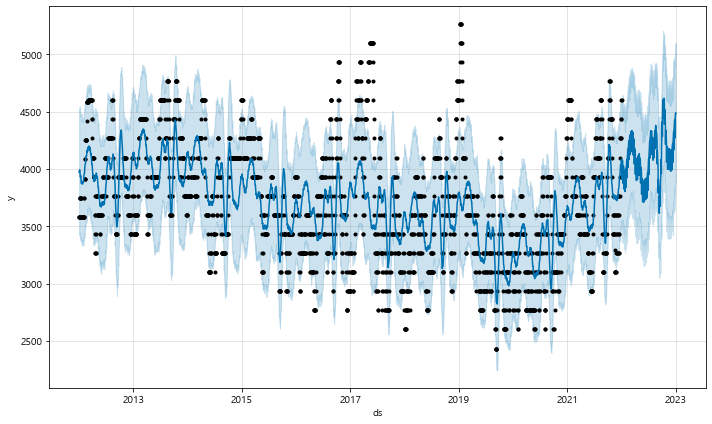

In [105]:
# 예측값 시각화
fig1 = m.plot(forecast)
# 검정색 점 : 실제 데이터 값
# 파란색 실선 : 예측값
# 하늘색 범위 : lower, upper 영역

In [106]:
# 한국 공휴일과 복날,조류독감 발생 반영

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name = 'KR').fit(data)

future = m.make_future_dataframe(periods=365)

forcast = m.predict(future)
forecast.tail()
forecast.to_csv('./holidays반영_5_6호닭_prophet_예측값.csv')

13:49:01 - cmdstanpy - INFO - Chain [1] start processing
13:49:02 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m,initial='1095 days', period='180 days', horizon='30 days')
df_cv.head()

  0%|          | 0/15 [00:00<?, ?it/s]

13:49:04 - cmdstanpy - INFO - Chain [1] start processing
13:49:04 - cmdstanpy - INFO - Chain [1] done processing
13:49:05 - cmdstanpy - INFO - Chain [1] start processing
13:49:05 - cmdstanpy - INFO - Chain [1] done processing
13:49:06 - cmdstanpy - INFO - Chain [1] start processing
13:49:07 - cmdstanpy - INFO - Chain [1] done processing
13:49:07 - cmdstanpy - INFO - Chain [1] start processing
13:49:08 - cmdstanpy - INFO - Chain [1] done processing
13:49:09 - cmdstanpy - INFO - Chain [1] start processing
13:49:09 - cmdstanpy - INFO - Chain [1] done processing
13:49:10 - cmdstanpy - INFO - Chain [1] start processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] done processing
13:49:14 - cmdstanpy - INFO - Chain [1] start processing
13:49:15 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-08,4011.866402,3661.035610,4307.677050,4267,2015-01-07
1,2015-01-09,4019.823357,3679.408144,4339.500539,4100,2015-01-07
2,2015-01-10,4008.114581,3701.544446,4314.315207,4100,2015-01-07
3,2015-01-12,3969.364269,3653.195824,4264.511246,4100,2015-01-07
4,2015-01-13,3959.358638,3628.498760,4298.257195,4100,2015-01-07


In [108]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,391008.380380,625.306629,502.764304,0.140376,0.151144,0.140161,0.550936
1,4 days,406614.359073,637.663202,526.533885,0.148916,0.152285,0.147526,0.513514
2,5 days,410059.507625,640.358890,522.422854,0.149813,0.152285,0.146819,0.567568
3,6 days,398418.054720,631.203656,503.479889,0.150168,0.148861,0.143845,0.554054
4,7 days,350344.667792,591.899204,464.692759,0.138669,0.136617,0.134011,0.584200
5,8 days,368728.417703,607.230119,467.143113,0.144518,0.123708,0.136969,0.582121
6,9 days,426261.949964,652.887395,493.112943,0.149175,0.105189,0.142526,0.604990
7,10 days,508431.622545,713.043913,544.795310,0.164948,0.117700,0.156253,0.621622
8,11 days,536429.231252,732.413293,571.507959,0.168936,0.126912,0.162762,0.594595
9,12 days,500313.299261,707.328283,564.687731,0.165683,0.135892,0.160148,0.594595
